In [1]:
import os
import matplotlib
matplotlib.use("Agg")
import numpy as np
from numpy import pi
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import logging,argparse
from data_loader import Data_loader
import model 
from hyperparams import Hyperparameters
import utils
from commons import tf_transform
import graph
from termcolor import colored 
import model_componets as comps
from commons import transform_util
import rules_numpy
import glob
from natsort import natsorted

Tensor("Const:0", shape=(3,), dtype=float32)
Tensor("Const_1:0", shape=(17, 3), dtype=float32)


In [2]:
print colored("code started","red")

H = Hyperparameters ()
D = Data_loader(H.data_path,H.seq_length,H.batch_size)
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

code started


In [ ]:
input_ph = tf.placeholder(tf.float32, shape= [None , H.num_joints ,3],name = 'skeleton_input')#without transformation 
gt_ph = tf.placeholder(tf.float32 , shape = [None, H.num_joints , 3], name = 'gt_input') #with transformation
global_step = tf.train.get_or_create_global_step()

def build_graph(model_input,rule_name,gt_flag = False ):
    encoder_out = graph.apply_pose_encoder(model_input)#root relative
    pose_encoder_params = graph.get_network_params("Encoder_net")#embeddings
    encoder_input = tf.reshape(encoder_out,(-1,H.seq_length,32))#sequence of embeddings
    encoder_lstm_out = model.apply_encoder(encoder_input,name ='motion_encoder')#motion embeddings
    z_state = encoder_lstm_out['z_state']
    z_outputs = encoder_lstm_out['z_outputs']
    if gt_flag == False:
        rule_net_out = model.apply_rule_net(z_state,rule_name)  ### NEWLY ADDED
        rule_state = rule_net_out['mapped_state'] ### NEWLY ADDED
        rule_outputs = rule_net_out['mapped_outputs'] ### NEWLY ADDED
    else :
        rule_net_out = encoder_lstm_out
        rule_state = z_state
        rule_outputs = z_outputs
    decoder_lstm_out = model.apply_decoder(rule_state,rule_outputs,name = 'motion_decoder')
    motion_recon = decoder_lstm_out['x_recon']
    motion_recon_reshaped = tf.reshape(motion_recon,((-1,32)))
    pose_recon = graph.apply_pose_decoder(motion_recon_reshaped)#view norm
    pose_decoder_params = graph.get_network_params("Decoder_net")
    rule_meta_outputs = {
        'model_input' : model_input,
        'encoder_lstm_out' : encoder_lstm_out,
        'rule_net_out' : rule_net_out,
        'decoder_lstm_out' : decoder_lstm_out,
        'pose_recon' : pose_recon,
        'pose_encoder_params' : pose_encoder_params,
        'pose_decoder_params' : pose_decoder_params
    }

    return rule_meta_outputs

preds = build_graph(input_ph,H.rule_network_name,gt_flag = False)
gt = build_graph(gt_ph,H.rule_network_name,gt_flag = True)


preds_rule_state = preds['rule_net_out']['mapped_state']
preds_enco_state = preds['encoder_lstm_out']['z_state']
gt_rule_state = gt['encoder_lstm_out']['z_state']

pose_decoder_preds = preds['pose_recon']


# loss = tf.reduce_mean((preds_rule_state - gt_rule_state )** 2)
# loss_summary = tf.summary.scalar('loss',loss)
# summary_op = tf.summary.merge_all()

pose_encoder_params = preds['pose_encoder_params']
pose_decoder_params = preds['pose_decoder_params']
param_lstm_encoder = model.get_network_params('motion_encoder')
param_lstm_decoder = model.get_network_params('motion_decoder')
rule_network_params = model.get_network_params(H.rule_network_name)

vars_to_minimize = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=H.rule_network_name) 
# loss_optimizer  = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(loss =loss,global_step=global_step,var_list = vars_to_minimize)

sess.run(tf.global_variables_initializer())

print colored("loading weights","blue")

tf.train.Saver(pose_encoder_params).restore(sess,'../pose_embedding_training_non_norm_range_ten_vneck/pretrained_weights/encoder_iter-1475001')
print colored("loaded pose_encoder weights","yellow")

tf.train.Saver(pose_decoder_params).restore(sess,'../pose_embedding_training_non_norm_range_ten_vneck/pretrained_weights/decoder_iter-1475001')
print colored("loaded pose_decoder weights","blue")

tf.train.Saver(param_lstm_encoder).restore(sess,'../motion_embedding_training_non_norm_range_ten_vneck/pretrained_weights/lstm_encoder/motion_net_expt_seq30_HuMaMpi91500')
print colored("loaded pose lstm_encoder weights","green")
#
tf.train.Saver(param_lstm_decoder).restore(sess,'../motion_embedding_training_non_norm_range_ten_vneck/pretrained_weights/lstm_decoder/motion_net_expt_seq30_HuMaMpi91500')
print colored("loaded pose lstm_decoder weights","green")

tf.train.Saver(vars_to_minimize).restore(sess,tf.train.latest_checkpoint('./weights/FlippedForwardNormalBackward/'))
print colored("loaded Rule weights","green")



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
loading weights
INFO:tensorflow:Restoring parameters from ../pose_embedding_training_non_norm_range_ten_vneck/pretrained_weights/encoder_iter-1475001
loaded pose_encoder weights
INFO:tensorflow:Restoring parameters from ../pose_embedding_training_non_norm_range_ten_vneck/pretrained_weights/decoder_iter-1475001
loaded pose_decoder weights
INFO:tensorflow:Restoring parameters from ../motion_embedding_training_non_norm_range_ten_vneck/pretrained_weights/lstm_encoder/motion_net_expt_seq30_HuMaMpi91500
loaded pose lstm_encoder weights
INFO:tensorflow:Restoring parameters from ../motion_embedding_training_non_norm_range_ten_vneck/pretrained_weights/lstm_decoder/motion_net_expt_seq30_HuMaMpi91500
loaded pose lstm_decoder weights
INFO:tensorflow:Restoring parameters from ./weights/FlippedForwardNormalBackward/motion_net_expt_seq30_HuMaMpi2600


In [4]:
# train_batch = np.asarray(D.get_sequence_batch_train())
# # train_batch = np.asarray(utils.augment_pose_seq(train_batch))
# train_batch = np.reshape((train_batch[:,0:30]),(-1,H.num_joints , 3))
# train_batch_cp = train_batch.reshape((-1,H.seq_length,H.num_joints * 3))
# gt_batch_reverse = np.array([list(reversed(i)) for i in train_batch_cp])
# gt_batch_reverse_flip = rules_numpy.x_flip(gt_batch_reverse.reshape((-1,H.num_joints,3)))

def get_normal_to_flip_data():
    train_batch = np.asarray(D.get_sequence_batch_train())
    train_batch = np.asarray(utils.augment_pose_seq(train_batch))
    train_batch = np.reshape((train_batch[:,0:30]),(-1,H.num_joints , 3))
    train_batch_cp = train_batch.reshape((-1,H.seq_length,H.num_joints * 3))
    gt_batch_reverse = np.array([list(reversed(i)) for i in train_batch_cp]).reshape((-1,H.num_joints,3))
    return train_batch,gt_batch_reverse


def get_flipped_forward_to_normal_backward():
    train_batch = np.asarray(D.get_sequence_batch_train())
    train_batch = np.asarray(utils.augment_pose_seq(train_batch))
    train_batch = np.reshape((train_batch[:,0:30]),(-1,H.num_joints , 3))
    train_batch_cp = train_batch.reshape((-1,H.seq_length,H.num_joints * 3)).copy()
    train_batch_flip = rules_numpy.x_flip(train_batch)
    gt_batch_reverse = np.array([list(reversed(i)) for i in train_batch_cp]).reshape((-1,H.num_joints,3))#sequence reverse
    return train_batch_flip , gt_batch_reverse

train_batch,gt_batch_reverse = get_normal_to_flip_data()
train_batch_flip , gt_batch_reverse = get_flipped_forward_to_normal_backward()



In [5]:
feed_dict = {input_ph : train_batch_flip , gt_ph : gt_batch_reverse}
op_train_dict = sess.run({ 'preds_rule_state': preds_rule_state , 'preds_enco_state':preds_enco_state}, feed_dict=feed_dict)


# feed_dict_first = {input_ph : train_batch , gt_ph : train_batch}
# feed_dict_second = {input_ph : gt_batch_reverse , gt_ph : gt_batch_reverse}

# op_train_dict_first = sess.run({ 'gt_rule_state': gt_rule_state}, feed_dict=feed_dict)
# op_train_dict_second = sess.run({ 'gt_rule_state': gt_rule_state}, feed_dict=feed_dict)



InternalError: Blas xGEMMBatched launch failed : a.shape=[1920,3,3], b.shape=[1920,3,1], m=3, n=1, k=3, batch_size=1920
	 [[Node: MatMul = BatchMatMul[T=DT_FLOAT, adj_x=false, adj_y=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](concat_1, strided_slice_24)]]
	 [[Node: motion_encoder/fully_connected/mul/_203 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4006_motion_encoder/fully_connected/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'MatMul', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/data/vcl/sid/rahul/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/tornado/ioloop.py", line 1017, in start
    self._run_callback(self._callbacks.popleft())
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-bf09378d87bf>", line 37, in <module>
    preds = build_graph(input_ph,H.rule_network_name,gt_flag = False)
  File "<ipython-input-3-bf09378d87bf>", line 6, in build_graph
    encoder_out = graph.apply_pose_encoder(model_input)#root relative
  File "graph.py", line 12, in apply_pose_encoder
    x_root_relative, x_local_real = comps.root_relative_to_local(x_real)
  File "model_componets.py", line 124, in root_relative_to_local
    sk_batch_local = tr.tf_global2local(skeleton_batch)
  File "commons/tf_transform.py", line 99, in tf_global2local
    dSl[i] = tf.matmul(R, dS[i][:, :, None])[:, :, 0]
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 1976, in matmul
    a, b, adj_x=adjoint_a, adj_y=adjoint_b, name=name)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1236, in batch_mat_mul
    "BatchMatMul", x=x, y=y, adj_x=adj_x, adj_y=adj_y, name=name)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas xGEMMBatched launch failed : a.shape=[1920,3,3], b.shape=[1920,3,1], m=3, n=1, k=3, batch_size=1920
	 [[Node: MatMul = BatchMatMul[T=DT_FLOAT, adj_x=false, adj_y=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](concat_1, strided_slice_24)]]
	 [[Node: motion_encoder/fully_connected/mul/_203 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4006_motion_encoder/fully_connected/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
op_train_dict['preds_rule_state'].shape
# op_train_dict_first['gt_rule_state'].shape

In [ ]:
op_train_dict['preds_enco_state'].shape

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X_r = pca.fit(op_train_dict['preds_rule_state']).transform(op_train_dict['preds_rule_state'])
%matplotlib inline
plt.scatter(X_r[:,0][:2] , X_r[:,1][:2],color = 'red' , lw =2)

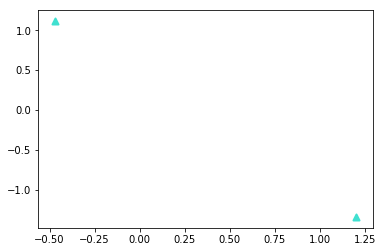

In [10]:
pca = PCA(n_components=2)
Y_r = pca.fit(op_train_dict['preds_enco_state']).transform(op_train_dict['preds_enco_state'])
%matplotlib inline
plt.scatter(Y_r[:,0][:2] , Y_r[:,1][:2] , color = 'turquoise',lw =2 ,marker = '^')

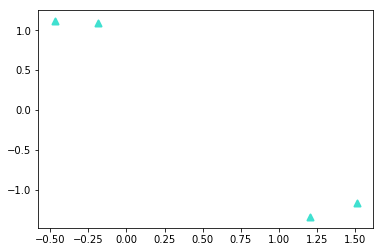

In [11]:
plt.scatter(list(X_r[:,0][:2]) + list(Y_r[:,0][:2]) , list(X_r[:,1][:2]) + list(Y_r[:,1][:2]) , color = 'turquoise',lw =2 ,marker = '^')

In [12]:
list(X_r[:,0][:2]) + list(Y_r[:,0][:2])

[-0.1893407, 1.5100745, -0.46805742, 1.202146]

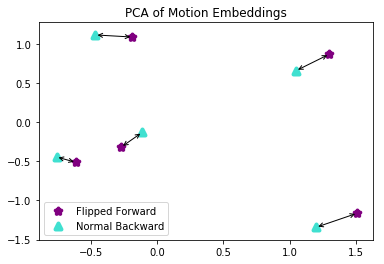

In [14]:
fig = plt.figure()

ax1 = fig.add_subplot(111)

ax1.scatter(X_r[:,0][:5] , X_r[:,1][:5],color = 'purple' , lw =4 , marker = '*',label = 'Flipped Forward')
ax1.scatter(Y_r[:,0][:5] , Y_r[:,1][:5] , color = 'turquoise',lw =4 ,marker = '^' , label = 'Normal Backward')

ax1.annotate(s='', xy=(X_r[0][0],X_r[0][1]), xytext=(Y_r[0][0],Y_r[0][1]), arrowprops=dict(arrowstyle='<->'))
ax1.annotate(s='', xy=(X_r[1][0],X_r[1][1]), xytext=(Y_r[1][0],Y_r[1][1]), arrowprops=dict(arrowstyle='<->'))
ax1.annotate(s='', xy=(X_r[2][0],X_r[2][1]), xytext=(Y_r[2][0],Y_r[2][1]), arrowprops=dict(arrowstyle='<->'))
ax1.annotate(s='', xy=(X_r[3][0],X_r[3][1]), xytext=(Y_r[3][0],Y_r[3][1]), arrowprops=dict(arrowstyle='<->'))
ax1.annotate(s='', xy=(X_r[4][0],X_r[4][1]), xytext=(Y_r[4][0],Y_r[4][1]), arrowprops=dict(arrowstyle='<->'))


plt.legend(loc='lower left');
plt.title('PCA of Motion Embeddings')

plt.show()
plt.savefig

In [23]:
X_r[0]

array([ 2.2402766 , -0.09671997], dtype=float32)

In [49]:
np.arange(30)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [2]:
import matplotlib
# matplotlib.use('Agg')
import glob
import scipy.io as sio
from natsort import natsorted
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
pi = math.pi
from commons import transform_util,skeleton_utils,vis_image
from termcolor import colored

In [3]:
limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]#17joints
# limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 0, 12, 13]#15joints

def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
    x, y, z = subplot
    ax = fig.add_subplot(subplot, projection='3d')

    lim = np.max(np.abs(joints_3d))
    ax.view_init(azim=az, elev=ele)

    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    return ax

def plot_skeleton(ax, ske,color_ours,az, ground_size=0.5):
        lcolor = color_ours[0]
        rcolor = color_ours[1]
        ax.grid(False)
#         # Hide axes ticks
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_zticks([])
#         plt.axis('off')
#         ax.set_aspect('equal')
        ax.elev = 10
        ax.azim = az
#         ax.azim = 0 
#         ax.dist = 9
#         ax.set_xlim(-10, 10)
#         ax.set_ylim(-10, 10)
#         ax.set_zlim(-10, 10)
        
        

        lim = np.max(np.abs(ske))
#         ax.view_init(azim=az, elev=ele)

        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_zlim(-lim, lim)
        
        ax.set_xlabel('x',labelpad=-8)
        ax.set_ylabel('y',labelpad=-8)
        ax.set_zlabel('z',labelpad = -10)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_zticklabels([])
        ax.axis('off')       




        # ax.set_aspect('equal')

#         ax.view_init(azim=90, elev=10)

        C = [{0: lcolor,  1: rcolor}[flag] for flag in lr_flags]
        P = limb_parents

        # Make connection matrix
#         joint_lines = []
        for i in range(ske.shape[0]):
            x = [ske[i, 0], ske[P[i], 0]]
            y = [ske[i, 1], ske[P[i], 1]]
            z = [ske[i, 2], ske[P[i], 2]]
#             x = [ske[i, 0]*1.2, ske[P[i]*1.2, 0]]
#             y = [ske[i, 1]*1.2, ske[P[i]*1.2, 1]]
#             z = [ske[i, 2]*1.2, ske[P[i]*1.2, 2]]
            
            # print x,y,z
            ax.plot(x, y, z, lw=6, c=C[i])

def get_all_plots(skeleton_strips_male,skeleton_strips_female):
    m = 15
    fig=plt.figure(figsize=(4  * 15 , 4))
    gs = gridspec.GridSpec(1, m)
    gs.update(wspace=0.05, hspace=0.0005) # set the spacing between axes. 

#     lcolor, rcolor = colors
    for j in range(m):
        idx = j
        ax = plt.subplot(gs[idx], projection='3d')
        color_ours = ['blue',  'green']
        plot_skeleton(ax, skeleton_strips_male[j],color_ours)
#         color_ours = ['#5879ff',  '#cc2520']
        color_ours = ['k','m']
        plot_skeleton(ax, skeleton_strips_female[j],color_ours)
        

    return fig



# color_ours = ['blue',  'green']
# color_ours = ['#5879ff',  '#cc2520']

lr_flags = [
    1, 1,
    1, 1, 1,
    0, 0, 0,
    1,
    1, 1, 1, 1,
    0, 0, 0, 0,
]

In [16]:
youtube_gt_pose_one = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/S8_Greeting 1_60457274_video_180_270_4.mat')['pose_3d']
youtube_gt_images_one = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S8_Greeting 1_60457274_video_180_270_4/*.png')


youtube_gt_pose_two = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/S8_Greeting 1_60457274_video_270_360_6.mat')['pose_3d']
youtube_gt_images_two = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S8_Greeting 1_60457274_video_270_360_6/*.png')


youtube_gt_pose_three = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/S8_Greeting 1_60457274_video_360_450_8.mat')['pose_3d']
youtube_gt_images_three = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S8_Greeting 1_60457274_video_360_450_8/*.png')

youtube_gt_pose_four = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/S8_Greeting 1_60457274_video_450_540_10.mat')['pose_3d']
youtube_gt_images_four = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S8_Greeting 1_60457274_video_450_540_10/*.png')


youtube_gt_pose_five = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/S8_Greeting 1_60457274_video_540_630_12.mat')['pose_3d']
youtube_gt_images_five = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S8_Greeting 1_60457274_video_540_630_12/*.png')


youtube_gt_pose_six = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/S8_Greeting 1_60457274_video_630_720_14.mat')['pose_3d']
youtube_gt_images_six = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S8_Greeting 1_60457274_video_630_720_14/*.png')




# youtube_gt_pose_one = sio.loadmat('/data/vcl/sid/in_the_w_parsed/simulated_3d_poses_new/dance_16_video_135_225_3.mat')['pose_3d']
# youtube_gt_images_one = glob.glob('/data/vcl/sid/in_the_w_parsed/img_normal/dance_16_video_135_225_3/*.png')

# youtube_gt_pose_two = sio.loadmat('/data/vcl/sid/in_the_w_parsed/simulated_3d_poses_new/dance_16_video_225_315_5.mat')['pose_3d']
# youtube_gt_images_two = glob.glob('/data/vcl/sid/in_the_w_parsed/img_normal/dance_16_video_225_315_5/*.png')

# youtube_gt_pose_three = sio.loadmat('/data/vcl/sid/in_the_w_parsed/simulated_3d_poses_new/dance_16_video_315_405_7.mat')['pose_3d']
# youtube_gt_images_three = glob.glob('/data/vcl/sid/in_the_w_parsed/img_normal/dance_16_video_315_405_7/*.png')

# youtube_gt_pose_four = sio.loadmat('/data/vcl/sid/in_the_w_parsed/simulated_3d_poses_new/dance_16_video_405_495_9.mat')['pose_3d']
# youtube_gt_images_four = glob.glob('/data/vcl/sid/in_the_w_parsed/img_normal/dance_16_video_405_495_9/*.png')

# youtube_gt_pose_five = sio.loadmat('/data/vcl/sid/in_the_w_parsed/simulated_3d_poses_new/dance_16_video_495_585_11.mat')['pose_3d']
# youtube_gt_images_five = glob.glob('/data/vcl/sid/in_the_w_parsed/img_normal/dance_16_video_495_585_11/*.png')

# youtube_gt_pose_six = sio.loadmat('/data/vcl/sid/in_the_w_parsed/simulated_3d_poses_new/dance_16_video_585_675_13.mat')['pose_3d']
# youtube_gt_images_six = glob.glob('/data/vcl/sid/in_the_w_parsed/img_normal/dance_16_video_585_675_13/*.png')

def getint(name):
    basename = name.split('_')[-1]
    num = basename.split('.')[0]
    return int(num)

youtube_gt_images_one.sort(key=getint)
gt_images_one = list(np.array(youtube_gt_images_one).copy())
# gt_images_one = natsorted(youtube_gt_images_one)
gt_pose_reshaped_one = youtube_gt_pose_one.reshape((-1,17,3))

youtube_gt_images_two.sort(key=getint)
gt_images_two = list(np.array(youtube_gt_images_two).copy())
# gt_images_two = natsorted(youtube_gt_images_two)
gt_pose_reshaped_two = youtube_gt_pose_two.reshape((-1,17,3))

youtube_gt_images_three.sort(key=getint)
gt_images_three = list(np.array(youtube_gt_images_three).copy())
# gt_images_three = natsorted(youtube_gt_images_three)
gt_pose_reshaped_three = youtube_gt_pose_three.reshape((-1,17,3))

youtube_gt_images_four.sort(key=getint)
gt_images_four = list(np.array(youtube_gt_images_four).copy())
# gt_images_four = natsorted(youtube_gt_images_four)
gt_pose_reshaped_four = youtube_gt_pose_four.reshape((-1,17,3))

youtube_gt_images_five.sort(key=getint)
gt_images_five = list(np.array(youtube_gt_images_five).copy())
# gt_images_five = natsorted(youtube_gt_images_five)
gt_pose_reshaped_five = youtube_gt_pose_five.reshape((-1,17,3))

youtube_gt_images_six.sort(key=getint)
gt_images_six = list(np.array(youtube_gt_images_six).copy())
# gt_images_six = natsorted(youtube_gt_images_six)
gt_pose_reshaped_six = youtube_gt_pose_six.reshape((-1,17,3))


big_image_seq = list(gt_images_one) + list(gt_images_two) + list(gt_images_three) + list(gt_images_four) + list(gt_images_five) + list(gt_images_six)
big_pose_seq = list(gt_pose_reshaped_one) + list(gt_pose_reshaped_two) + list(gt_pose_reshaped_three) + list(gt_pose_reshaped_four) +list(gt_pose_reshaped_five) +list(gt_pose_reshaped_six) 

# gt_images_full = gt_images_or[30:90][::4]
# gt_poses_full = gt_pose_reshaped_or[30:90][::4]


# gt_images_full_prior = gt_images_prior_or[60:90][::4] + gt_images_or[0:30][::4]
# gt_poses_full_prior = gt_pose_reshaped_prior_or[60:90][::4] + gt_pose_reshaped_or[0:30][::4]



# gt_images_full_post = gt_images_post_or[0:60][::4]
# gt_poses_full_post = gt_pose_reshaped_post_or[0:60][::4]

# gt_images_full = big_image_seq[::4][27:42]#mads
# gt_poses_full = big_pose_seq[::4][27:42]#mads


gt_images_full = big_image_seq[::8][19:49]

gt_poses_full = big_pose_seq[::8][19:49]


print len(gt_images_full)
print len(gt_poses_full)


30
30


In [3]:
def get_sequence_data():
    while True :
        try :
            path = '/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/'
            k = natsorted(glob.glob(path+'*'))
            categories= [i.split('/')[-1].split('.')[0] for i in k]
            videos = [i.split('video')[0] for i in categories]
            from collections import Counter 
            vid_keys = dict(Counter(videos)).keys()

            rand_key = np.random.choice(vid_keys)
            req_vid = [i for i in k if rand_key in i]
            rand_ord = req_vid[np.random.choice([0,1])::2]
            arr= []
            for i in range(len(rand_ord)-5):
                arr.append(rand_ord[i:i+6])
            rand_seq = [i.replace('.mat','').split('/')[-1] for i in arr[np.random.choice(np.arange(len(arr)))]]



            youtube_gt_pose_one = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/'+rand_seq[0]+'.mat')['pose_3d']
            youtube_gt_images_one = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/'+rand_seq[0]+'/*.png')


            youtube_gt_pose_two = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/'+rand_seq[1]+'.mat')['pose_3d']
            youtube_gt_images_two = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/'+rand_seq[1]+'/*.png')


            youtube_gt_pose_three = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/'+rand_seq[2]+'.mat')['pose_3d']
            youtube_gt_images_three = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/'+rand_seq[2]+'/*.png')

            youtube_gt_pose_four = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/'+rand_seq[3]+'.mat')['pose_3d']
            youtube_gt_images_four = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/'+rand_seq[3]+'/*.png')


            youtube_gt_pose_five = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/'+rand_seq[4]+'.mat')['pose_3d']
            youtube_gt_images_five = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/'+rand_seq[4]+'/*.png')


            youtube_gt_pose_six = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/simulated_3d_poses/'+rand_seq[5]+'.mat')['pose_3d']
            youtube_gt_images_six = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/center_crops/'+rand_seq[5]+'/*.png')

            def getint(name):
                basename = name.split('_')[-1]
                num = basename.split('.')[0]
                return int(num)

            youtube_gt_images_one.sort(key=getint)
            gt_images_one = list(np.array(youtube_gt_images_one).copy())
            # gt_images_one = natsorted(youtube_gt_images_one)
            gt_pose_reshaped_one = youtube_gt_pose_one.reshape((-1,17,3))

            youtube_gt_images_two.sort(key=getint)
            gt_images_two = list(np.array(youtube_gt_images_two).copy())
            # gt_images_two = natsorted(youtube_gt_images_two)
            gt_pose_reshaped_two = youtube_gt_pose_two.reshape((-1,17,3))

            youtube_gt_images_three.sort(key=getint)
            gt_images_three = list(np.array(youtube_gt_images_three).copy())
            # gt_images_three = natsorted(youtube_gt_images_three)
            gt_pose_reshaped_three = youtube_gt_pose_three.reshape((-1,17,3))

            youtube_gt_images_four.sort(key=getint)
            gt_images_four = list(np.array(youtube_gt_images_four).copy())
            # gt_images_four = natsorted(youtube_gt_images_four)
            gt_pose_reshaped_four = youtube_gt_pose_four.reshape((-1,17,3))

            youtube_gt_images_five.sort(key=getint)
            gt_images_five = list(np.array(youtube_gt_images_five).copy())
            # gt_images_five = natsorted(youtube_gt_images_five)
            gt_pose_reshaped_five = youtube_gt_pose_five.reshape((-1,17,3))

            youtube_gt_images_six.sort(key=getint)
            gt_images_six = list(np.array(youtube_gt_images_six).copy())
            # gt_images_six = natsorted(youtube_gt_images_six)
            gt_pose_reshaped_six = youtube_gt_pose_six.reshape((-1,17,3))


            big_image_seq = list(gt_images_one) + list(gt_images_two) + list(gt_images_three) + list(gt_images_four) + list(gt_images_five) + list(gt_images_six)
            big_pose_seq = list(gt_pose_reshaped_one) + list(gt_pose_reshaped_two) + list(gt_pose_reshaped_three) + list(gt_pose_reshaped_four) +list(gt_pose_reshaped_five) +list(gt_pose_reshaped_six) 

            gt_images_full = big_image_seq[::8][19:49]

            gt_poses_full = big_pose_seq[::8][19:49]

            #########################SLOW#####################
            def mid(arr, n):
                L = len(arr)
                if n <= 0:
                    return ''
                elif n < L:
                    Lr = L % 2
                    a, ar = divmod(L-n, 2)
                    b, br = divmod(L+n, 2)
                    a += Lr*ar
                    b += Lr*br
                    arr = arr[a:b]
                return arr


            gt_images_all = big_image_seq[::4]
            gt_poses_all = big_pose_seq[::4]


            gt_images_small = gt_images_all[::2]
            gt_poses_small = gt_poses_all[::2]


            seq_temp_images = mid(gt_images_small,30)
            seq_temp_poses = mid(gt_poses_small,30)
            twox_images =  seq_temp_images

            twox_poses = seq_temp_poses

            seq_twox_images = mid(seq_temp_images,15)
            seq_twox_poses = mid(seq_temp_poses,15)
            # print len(seq_twox_poses)
            index_all_begin =  gt_images_all.index(seq_twox_images[0])

            index_all_end =  gt_images_all.index(seq_twox_images[-1]) + 2

            seq_onex_images = gt_images_all[index_all_begin:index_all_end ] 
            seq_onex_poses = gt_poses_all[index_all_begin:index_all_end ] 


            onex_images = np.array(seq_onex_images)

            onex_poses = np.array(seq_onex_poses)

            gt_images_all_2 = big_image_seq[::2]
            gt_poses_all_2 = big_pose_seq[::2]

            seq_halfx_images = mid(onex_images,15)
            seq_halfx_poses = mid(onex_poses,15)

            index_all_begin =  gt_images_all_2.index(seq_halfx_images[0])

            index_all_end =  gt_images_all_2.index(seq_halfx_images[-1]) + 2

            seq_halfx_images = gt_images_all_2[index_all_begin:index_all_end ] 
            seq_halfx_poses = np.array(gt_poses_all_2[index_all_begin:index_all_end ] )
            break 
        except :
            pass

    return twox_images,twox_poses,onex_images,onex_poses,seq_halfx_images,seq_halfx_poses


In [4]:
final_data = []

for i in range(50):
    final_data.append(get_sequence_data())
    
    

In [5]:
twox_images = [i[0] for i in final_data]
twox_poses = np.array([i[1] for i in final_data])
onex_images = [i[2] for i in final_data]
onex_poses = np.array([i[3] for i in final_data])
seq_halfx_images = [i[4] for i in final_data]
seq_halfx_poses = np.array([i[5] for i in final_data])

In [6]:
flipped_forward = np.array(rules_numpy.x_flip(np.reshape((onex_poses),(-1,H.num_joints , 3))))
normal_backward = np.array([list(reversed(i)) for i in onex_poses.reshape((-1,H.seq_length,H.num_joints * 3))]).reshape((-1,H.num_joints,3))
fast_forward = np.array(twox_poses).reshape((-1,H.num_joints,3))
slow_backward = np.array([list(reversed(i)) for i in seq_halfx_poses.reshape((-1,H.seq_length,H.num_joints * 3))]).reshape((-1,H.num_joints,3))
original_sequence = onex_poses.reshape((-1,H.num_joints,3))

In [7]:
# What are the rules:
# Rule 1 - Flipped-forward-to-normal-backward
# Rule 2 - Fast-forward-to-slow-backward


In [8]:

input_ph = tf.placeholder(tf.float32, shape= [None , H.num_joints ,3],name = 'skeleton_input')

global_step = tf.train.get_or_create_global_step()

encoder_out = graph.apply_pose_encoder(input_ph)#root relative

pose_encoder_params = graph.get_network_params("Encoder_net")#embeddings

encoder_input = tf.reshape(encoder_out,(-1,H.seq_length,32))#sequence of embeddings

encoder_lstm_out = model.apply_encoder(encoder_input,name ='motion_encoder')

z_state = encoder_lstm_out['z_state']

z_outputs = encoder_lstm_out['z_outputs']

decoder_lstm_out = model.apply_decoder(z_state,z_outputs,name = 'motion_decoder')

motion_recon = decoder_lstm_out['x_recon']

motion_recon_reshaped = tf.reshape(motion_recon,((-1,32)))

pose_recon = graph.apply_pose_decoder(motion_recon_reshaped)#view norm

pose_decoder_params = graph.get_network_params("Decoder_net")

loss_motion = tf.reduce_mean((pose_recon - input_ph)**2)

param_lstm_encoder = model.get_network_params('motion_encoder')

param_lstm_decoder = model.get_network_params('motion_decoder')

sess.run(tf.global_variables_initializer())

print colored("loading weights","blue")

tf.train.Saver(pose_encoder_params).restore(sess,'../pose_embedding_training_non_norm_range_ten_vneck/pretrained_weights/encoder_iter-1475001')
print colored("loaded pose_encoder weights","yellow")

tf.train.Saver(pose_decoder_params).restore(sess,'../pose_embedding_training_non_norm_range_ten_vneck/pretrained_weights/decoder_iter-1475001')
print colored("loaded pose_decoder weights","blue")

tf.train.Saver(param_lstm_encoder).restore(sess,tf.train.latest_checkpoint('../motion_embedding_training_non_norm_range_ten_vneck/weights/lstm_encoder/'))
print colored("loaded pose lstm_encoder weights","green")
#
tf.train.Saver(param_lstm_decoder).restore(sess,tf.train.latest_checkpoint('../motion_embedding_training_non_norm_range_ten_vneck/weights/lstm_decoder/'))
print colored("loaded pose lstm_decoder weights","red")


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
loading weights
INFO:tensorflow:Restoring parameters from ../pose_embedding_training_non_norm_range_ten_vneck/pretrained_weights/encoder_iter-1475001
loaded pose_encoder weights
INFO:tensorflow:Restoring parameters from ../pose_embedding_training_non_norm_range_ten_vneck/pretrained_weights/decoder_iter-1475001
loaded pose_decoder weights
INFO:tensorflow:Restoring parameters from ../motion_embedding_training_non_norm_range_ten_vneck/weights/lstm_encoder/motion_net_expt_seq30_HuMaMpi91500
loaded pose lstm_encoder weights
INFO:tensorflow:Restoring parameters from ../motion_embedding_training_non_norm_range_ten_vneck/weights/lstm_decoder/motion_net_expt_seq30_HuMaMpi91500
loaded pose lstm_decoder weights


In [9]:

# feed_dict = {input_ph : original_sequence}

# op_train_dict = sess.run({'loss':loss_motion, 'z_state': z_state}, feed_dict=feed_dict)

In [10]:
flipped_forward_dict = sess.run({'loss':loss_motion, 'z_state': z_state}, feed_dict={input_ph : flipped_forward})
normal_backward_dict = sess.run({'loss':loss_motion, 'z_state': z_state}, feed_dict={input_ph : normal_backward})
fast_forward_dict = sess.run({'loss':loss_motion, 'z_state': z_state}, feed_dict={input_ph : fast_forward})
slow_backward_dict = sess.run({'loss':loss_motion, 'z_state': z_state}, feed_dict={input_ph : slow_backward})
original_sequence_dict = sess.run({'loss':loss_motion, 'z_state': z_state}, feed_dict={input_ph : original_sequence})

In [20]:
poses_dict = {'flipped_forward' : flipped_forward,
              'normal_backward' : normal_backward,
              'fast_forward' : fast_forward,
              'slow_backward' : slow_backward,
              'original_sequence' : original_sequence}

sio.savemat('./pca_poses.mat',poses_dict)

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

final_dict_ = [flipped_forward_dict,normal_backward_dict,fast_forward_dict,slow_backward_dict,original_sequence_dict]

pca_x = []
pca_y = []
for  i in final_dict_:
    pca = PCA(n_components=2)
    X_r = pca.fit(i['z_state']).transform(i['z_state'])
    pca_x.append(X_r[:,0][0])
    pca_y.append(X_r[:,1][0])
#     %matplotlib inline
#     plt.scatter(X_r[:,0][:1] , X_r[:,1][:1],color = 'red' , lw =2)

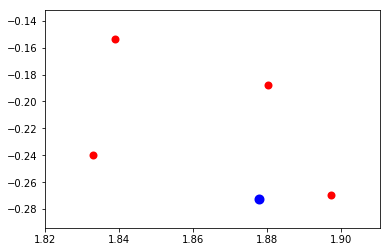

In [19]:
%matplotlib inline
index = 2
plt.scatter(pca_x , pca_y,color = 'red' , lw =2)
plt.scatter(pca_x[index] , pca_y[index],color = 'blue' , lw =4)


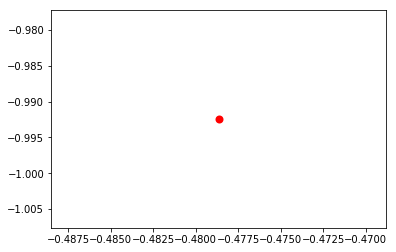

In [35]:
pca = PCA(n_components=2)
X_r = pca.fit(normal_backward_dict['z_state']).transform(normal_backward_dict['z_state'])
%matplotlib inline
plt.scatter(X_r[:,0][:1] , X_r[:,1][:1],color = 'red' , lw =2)

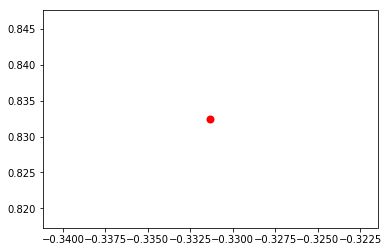

In [31]:
pca = PCA(n_components=2)
X_r = pca.fit(fast_forward_dict['z_state']).transform(fast_forward_dict['z_state'])
%matplotlib inline
plt.scatter(X_r[:,0][:1] , X_r[:,1][:1],color = 'red' , lw =2)

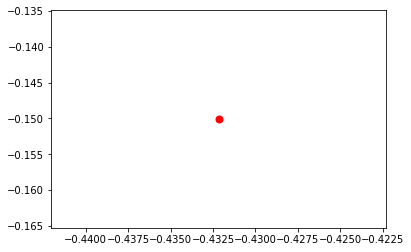

In [32]:
pca = PCA(n_components=2)
X_r = pca.fit(slow_backward_dict['z_state']).transform(slow_backward_dict['z_state'])
%matplotlib inline
plt.scatter(X_r[:,0][:1] , X_r[:,1][:1],color = 'red' , lw =2)

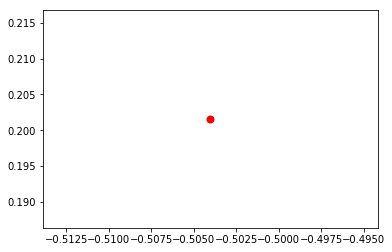

In [33]:
pca = PCA(n_components=2)
X_r = pca.fit(original_sequence_dict['z_state']).transform(original_sequence_dict['z_state'])
%matplotlib inline
plt.scatter(X_r[:,0][:1] , X_r[:,1][:1],color = 'red' , lw =2)

In [47]:
!ls


check_data.ipynb  model_componets.py			 test_train.png
commons		  model_componets.pyc			 test_valid.png
data_loader.py	  model.py				 train.py
data_loader.pyc   model.pyc				 utils.py
graph.py	  motion_embedding_rules_pca_plot.ipynb  utils.pyc
graph.pyc	  pretrained_weights			 vis_image.py
hyperparams.py	  rules_numpy.py			 vis_image.pyc
hyperparams.pyc   rules_numpy.pyc			 visualizations.ipynb
logs		  scrap_notebook.ipynb			 weights


In [48]:
k= glob.glob('/data/vcl/anirudh_rule_based/codes_2020/reqd/new_sid_plots/new_sid_plots/*/main_fig_3d.png')

In [51]:
for i in k :
    file_name = i.split("/")[-2]
    print (file_name)
    os.system("cp -r {} {}".format(i,'/data/vcl/anirudh_rule_based/codes_2020/reqd/'+file_name+'.png'))

wild_courtyard_capoeira
youtube_dance_104
mpi_TS1
youtube_dance_103
youtube_dance_10
youtube_dance_8
human_S9_Discussion
wild_outdoors_climbing
wild_courtyard_arguing
mpi_TS3
human_S11_Posing
human_S11_Walking
human_S11_Greeting
youtube_dance_3
wild_courtyard_goodNews
mpi_TS4
mpi_TS6
mpi_TS2
mpi_TS5
human_S11_Discussion
wild_courtyard_bodyScannerMotions
human_S9_Smoking
wild_outdoors_slalom
youtube_dance_24
youtube_dance_34
youtube_dance_35
youtube_dance_110
human_S9_WalkDog
human_S9_Purchases
youtube_dance_102
